# 价值因子

## 基本逻辑

价值因子有效性的一般来源: 利润(Earnings), 收入(Sales), 现金流(Cash Flows), 或者账面价值(Book Values)相似的资产应该具有相似的价格, 换句话说, 所有的公司应该有相似的市盈率(Price to Earings, P/E), 市销率(Price to Sales, P/S), 市现率(Price to Cash Flow, P/CF), 以及市净率(Price to Book, P/B)等指标. 但在现实的市场中, 可能会发生暂时性的偏离, 主要原因有:
* 投资者没有充分的考虑到价格而错误的将一个好公司等同于一只好股票;
* 投资者倾向于将近期的过于乐观或者悲观的增长率外推到未来;
* 投资者对公司基本面变化或者新闻反应过度或者反应不足.

然而, 从长期来看, 价格将收敛到内在价值, 导致收敛的行为主要有:
* 投资者买入低估的股票, 卖出高估股票
* 低估的公司被收购
* 现金流充沛的被低估的公司会回购自己的股票

在价格收敛到价值的过程中, 被低估的公司相对于被高估的公司会表现出超额收益.

## 价值因子库

In [1]:
# coding=utf-8
import time
import sys
import os
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
sys.path.append("C:\\Users\\hushuntai\\svn\\python")

from IPython.display import display
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib.pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdate
from tqdm import tqdm_notebook

pd.set_option("max_rows", None, "max_colwidth", 1000)
FactorInfo = pd.read_csv(".\\csv\\价值因子.csv", header=0, index_col=0, encoding="utf-8")
display(FactorInfo)

,因子描述,排序方向,数据类型
因子名称,,,
DP_LTM,过去一年现金分红 / 总市值,降序,double
EP_LYR,净利润(不含少数股东损益)_最新年报 / 总市值,降序,double
EP_TTM,净利润(不含少数股东损益)_TTM / 总市值,降序,double
EP_SQ,净利润_最近预测年度 / 总市值,降序,double
EP_FY0,一致预期净利润_FY0 / 总市值,降序,double
EP_FY1,一致预期净利润_FY1 / 总市值,降序,double
EP_Fwd12M,每股收益_未来12个月预测值 / 收盘价,降序,double
EP_TTM_Deducted,扣除非经常性损益后净利润_TTM / 总市值,降序,double
OCFP_TTM,经营活动产生的现金流量净额_TTM / 总市值,降序,double


因子后缀说明：
* LYR: 表示使用当前时点可见的最新年报数据计算因子值;
* LR: 表示使用当前时点可见的最新财报数据计算因子值;
* TTM: 表示使用当前时点可见的所有财报数据计算出来的滚动四个季度值, 假设当前可见的最新财报是一季报, 那么, 滚动四季度 = 本年一季报 + 去年年报 - 去年一季报;
* SQ: 表示使用当前时点可见的所有财报数据计算出来的单季度值, 假设当前可见的最新财报是中报, 那么, 单季度 = 本年中报 – 本年一季报;
* Fwd12M: 表示使用当前时点可见的分析师预期数据计算出的未来 12 个月预期因子值，假设当前可见的最新年报是 2016 年年报，那么取分析师对 2017 年年报和 2018 年年报的一致预期值加权平均所得, 加权的权重如下定义: 假设当前时点为 2017 年 7 月 27 日, 距离2017 年 12 月 31 日有 157 天, 那么 2017 年年报一致预期值的权重为 157 / 365 = 0.43, 2018 年年报一致预期值的权重为 0.57;
* FY0: 最近预测年度的分析师预测值, 假设当前时点可见的最新年报是 2017 年年报, 则取分析师对 2018 年年报的一致预期值;
* FY1: 最近预测年度下一年度的分析师预测值, 假设当前时点可见的最新年报是 2017 年年报, 取分析师对 2019 年年报的一致预期值;

价值因子主要有以下几类:
* 以利润或收入计量价值: 比如市盈率, 市销率等等.
* 以现金流计量价值: 比如市现率等. 相比于利润, 现金流的抗操纵性较好.
* 以分红计量价值: 比如股息率等.
* 以账面价值计量价值: 比如市净率等.


**企业价值(Enterprise Value, EV)**

大多数的价值因子是以比率的形式表达. 作为分母的量通常为市值或者企业价值, 其中, 企业价值的计算公式如下: 企业价值 = 总市值 + 优先股价值 + 负债 - 现金及现金等价物. 企业价值是收购方收购企业时需要支付的理论价格. 因为企业拥有的现金及现金等价物可以直接抵扣收购成本, 所以将其从中减去. 基于企业价值的价值因子可以认为是去杠杆后的调整值, 在比较杠杆水平差异较大的公司时比较合适.


**价值陷阱(Value Trap)**

部分研究者认为价值因子溢价并不是来源于投资者行为偏差的错误定价, 而是对承担系统性风险的补偿. 比如, 平均来看价值股倾向于更高的价格波动性, 并且分析师对其的覆盖程度较低. Gray 和 Vogel(2011) 的研究分析了 EBITA/EV, E/P, FCF/EV, B/P 这些价值因子从 1971 年到 2010 年的表现, 发现价值因子虽然从长期来看具有正的超额收益(其中, EBITA/EV 因子具有最高的风险调整后收益), 但价值因子普遍有较高的最大回撤(超过 50%). 单独使用价值因子很难产生较高的风险调整后收益. 

价值陷阱现象是指价值因子值较高但收入或者利润持续下降的股票其未来的价格走势反而向下.


**FSCORE**

为了避免价值陷阱, Joseph Piotroski(2000) 提出了筛选价值股的九条准则:
* 净利润(Net Income): 净利润(或者 ROE)为正
* ROA(Return on Asset): ROA 比前一年高
* 经营性现金流(Operating Cash Flow): 经营性现金流为正
* 盈利质量(Earnings Quality): 经营性现金流比净利润高
* 毛利率(Gross Margin): 毛利率比前一年高
* 资产周转率(Asset Turnover): 资产周转率比前一年高
* 杠杆率(Leverage): 资产负债率(Debt to Asset Ratio)比前一年低
* 流动比率(Current Ratio): 流动比率比前一年高
* 流通股(Shares Outstanding): 复权调整的流通股不高于前一年

每通过一条准则记 1 分, 不通过记 0 分, 则将得分加总即为 FSCORE, FSCORE 在 8 以上为好股票, 0~1 为差股票.



## 因子测试

由于大多数价值因子涉及公司的财务数据, 而财务报表每个季度发布一次, 季度内因子值的变化仅仅依赖于股票价格的变动, 所以因子的预测期不宜过短, 这里以月度为预测期. 

下面从 IC, Fama-MacBeth 回归, 行业分布以及因子间相关性对价值类因子进行测试:

==========历史回测==========
1. 初始化耗时 : 9.85
2. 循环计算

100% (132 of 132) |#######################| Elapsed Time: 0:02:51 Time: 0:02:51


耗时 : 171.03
3. 结果生成耗时 : 0.52
总耗时 : 181.40


,平均值,标准差,最小值,最大值,IC_IR,t统计量,平均股票数,IC×Sqrt(N),有效期数
BP_LR,4.86%,15.07%,-28.15%,44.21%,0.3224,3.69,2228.36,2.29,131
BP_LR_Tangible,4.60%,13.77%,-24.62%,40.22%,0.3344,3.83,2228.36,2.17,131
DP_LTM,2.07%,12.51%,-29.95%,37.14%,0.1652,1.89,2190.14,0.97,131
EBIT2EV,2.12%,10.38%,-19.01%,30.31%,0.2046,2.34,2139.34,0.98,131
EBITDA2EV,2.25%,11.38%,-26.47%,35.91%,0.1980,2.27,2139.34,1.04,131
EP_FY0,4.38%,15.79%,-29.02%,41.62%,0.2772,3.17,1450.74,1.67,131
EP_FY1,5.53%,16.12%,-29.38%,44.41%,0.3429,3.92,1484.42,2.13,131
EP_Fwd12M,5.58%,16.18%,-29.41%,42.73%,0.3448,3.95,1476.47,2.14,131
EP_LYR,1.42%,11.55%,-23.47%,35.05%,0.1234,1.41,2180.88,0.67,131
EP_SQ,3.16%,11.57%,-20.04%,34.82%,0.2728,3.12,2191.24,1.48,131

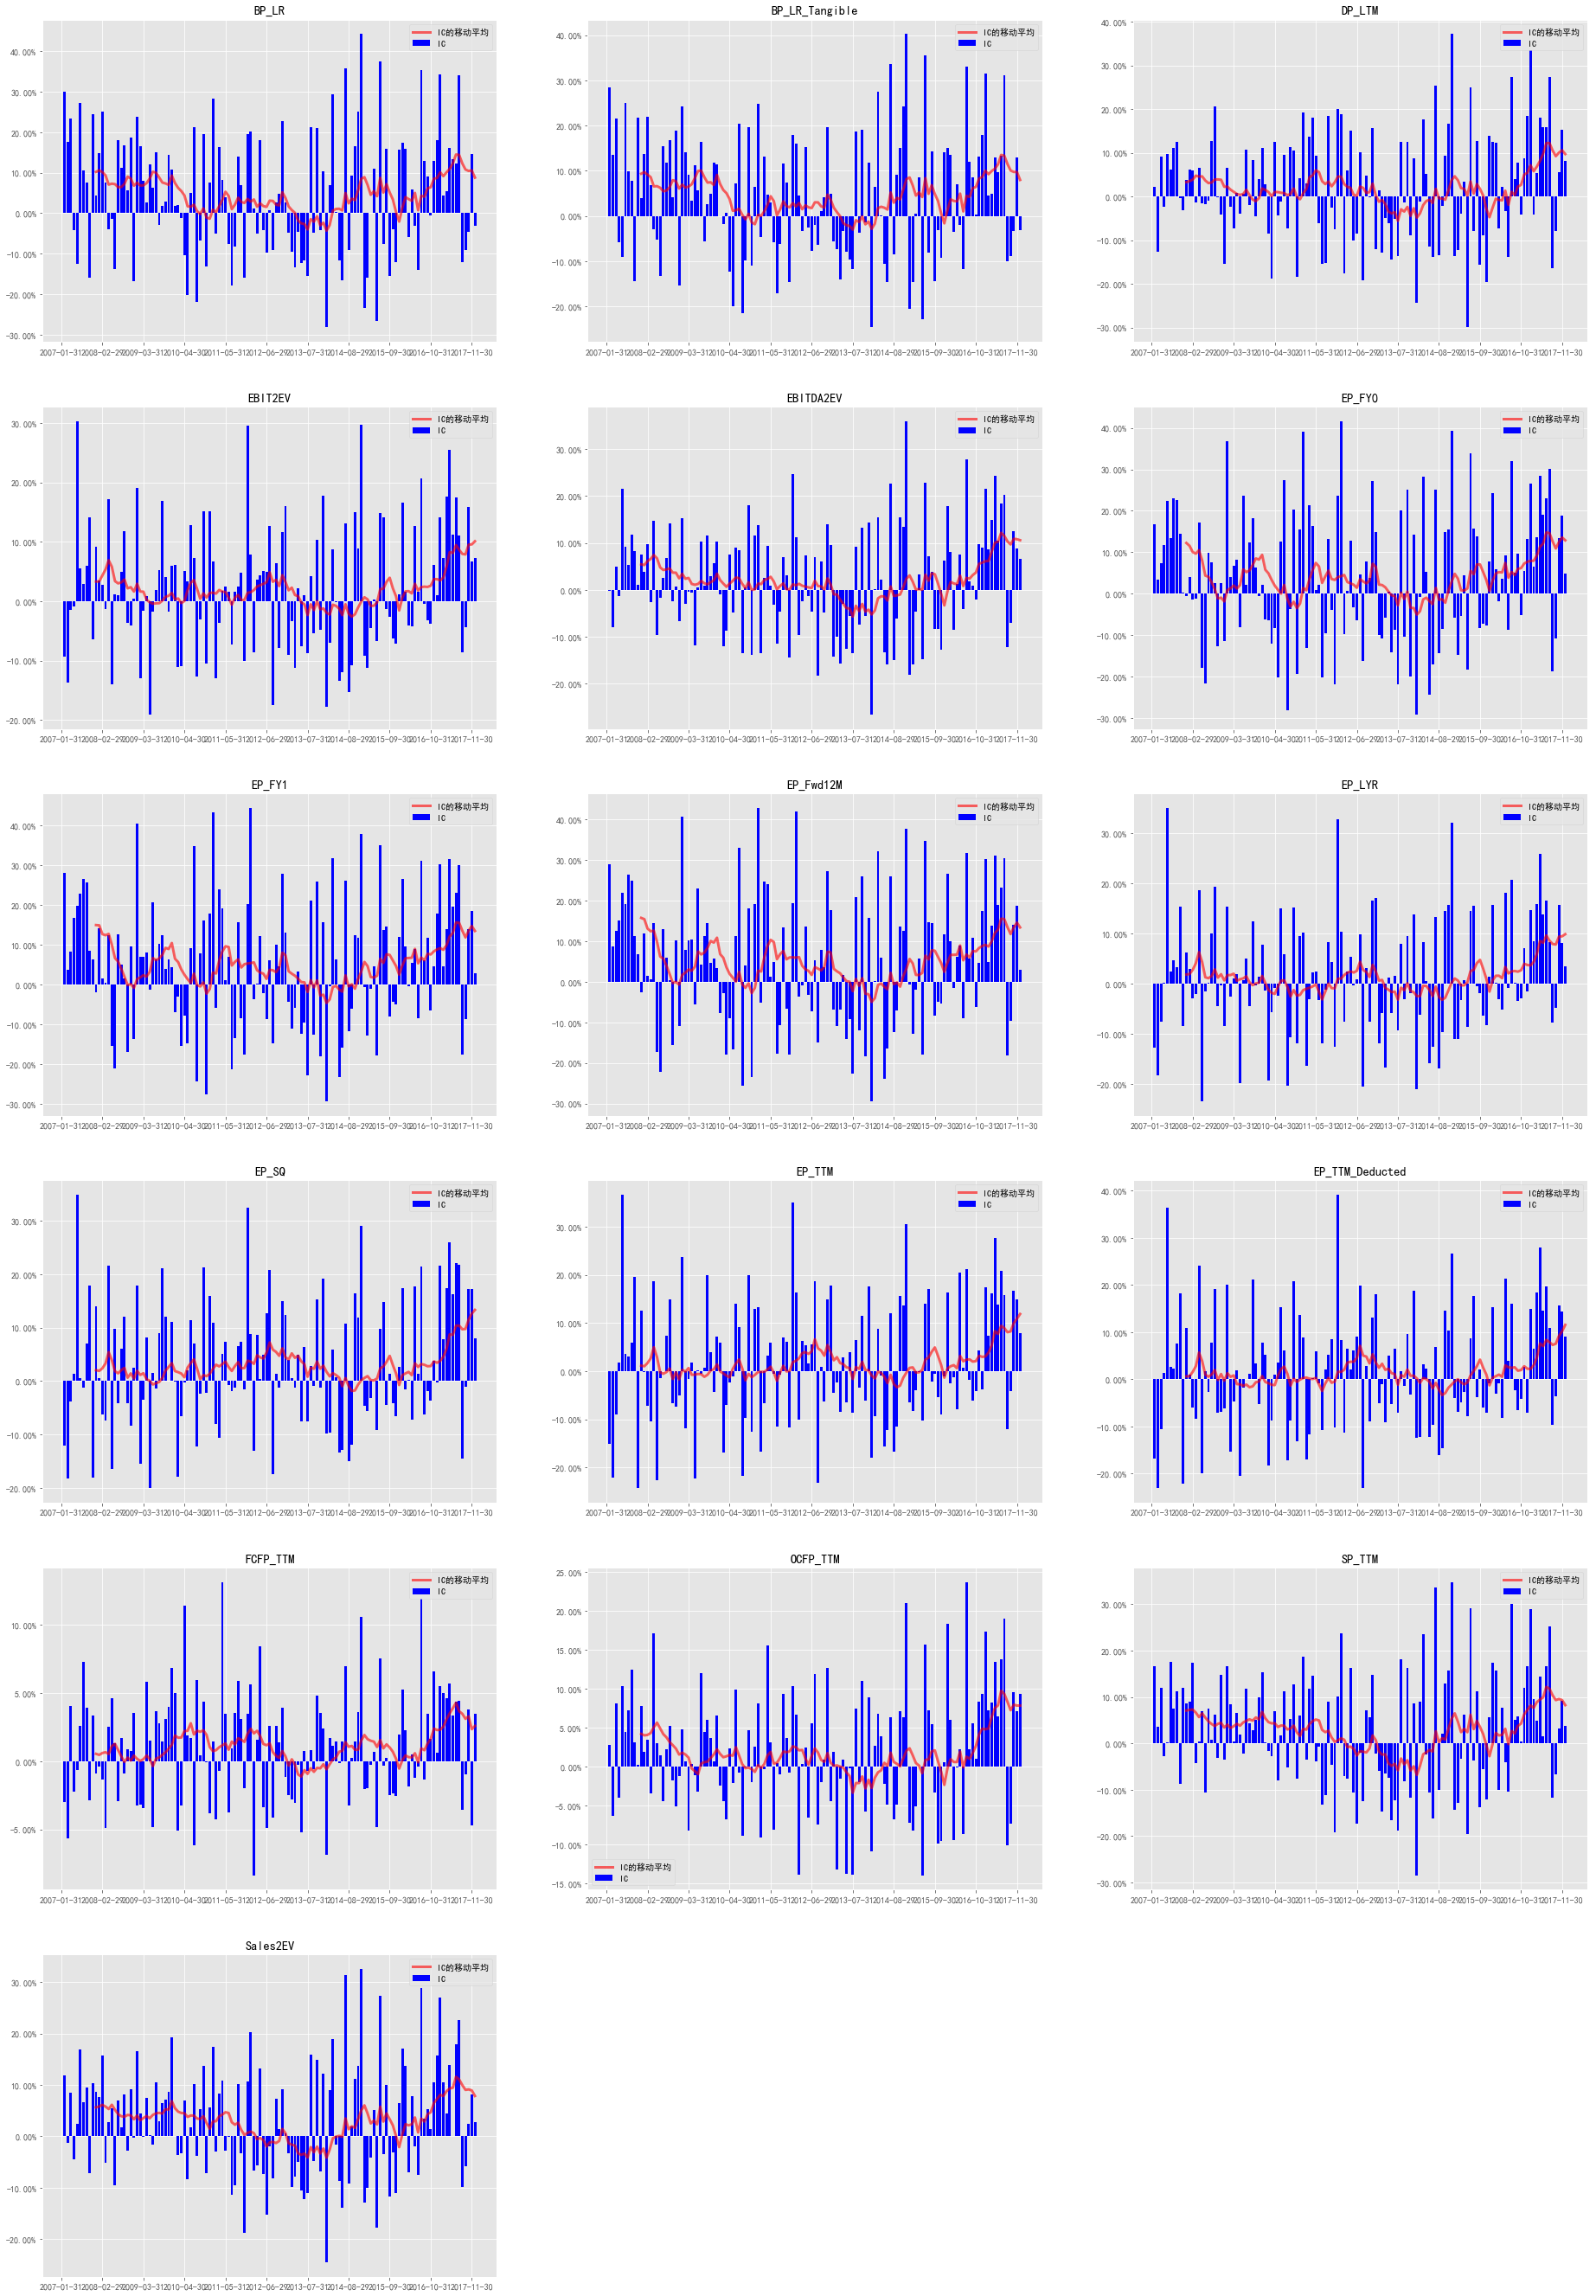
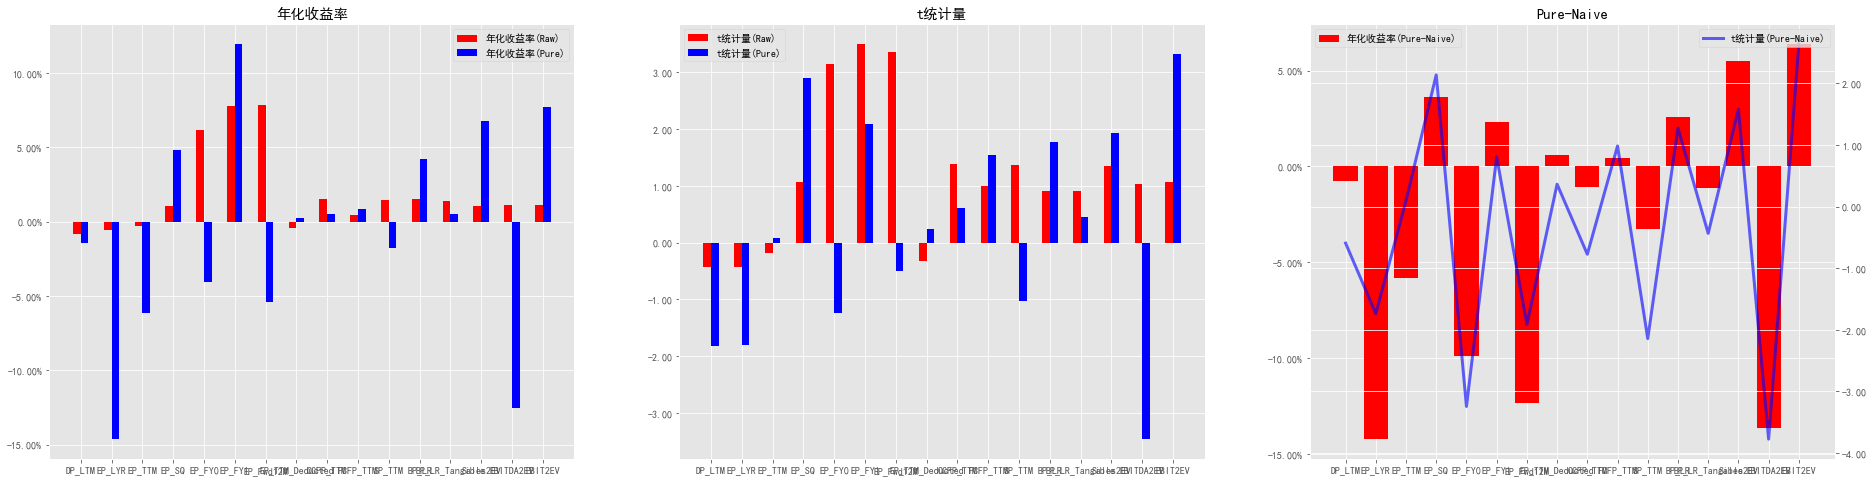
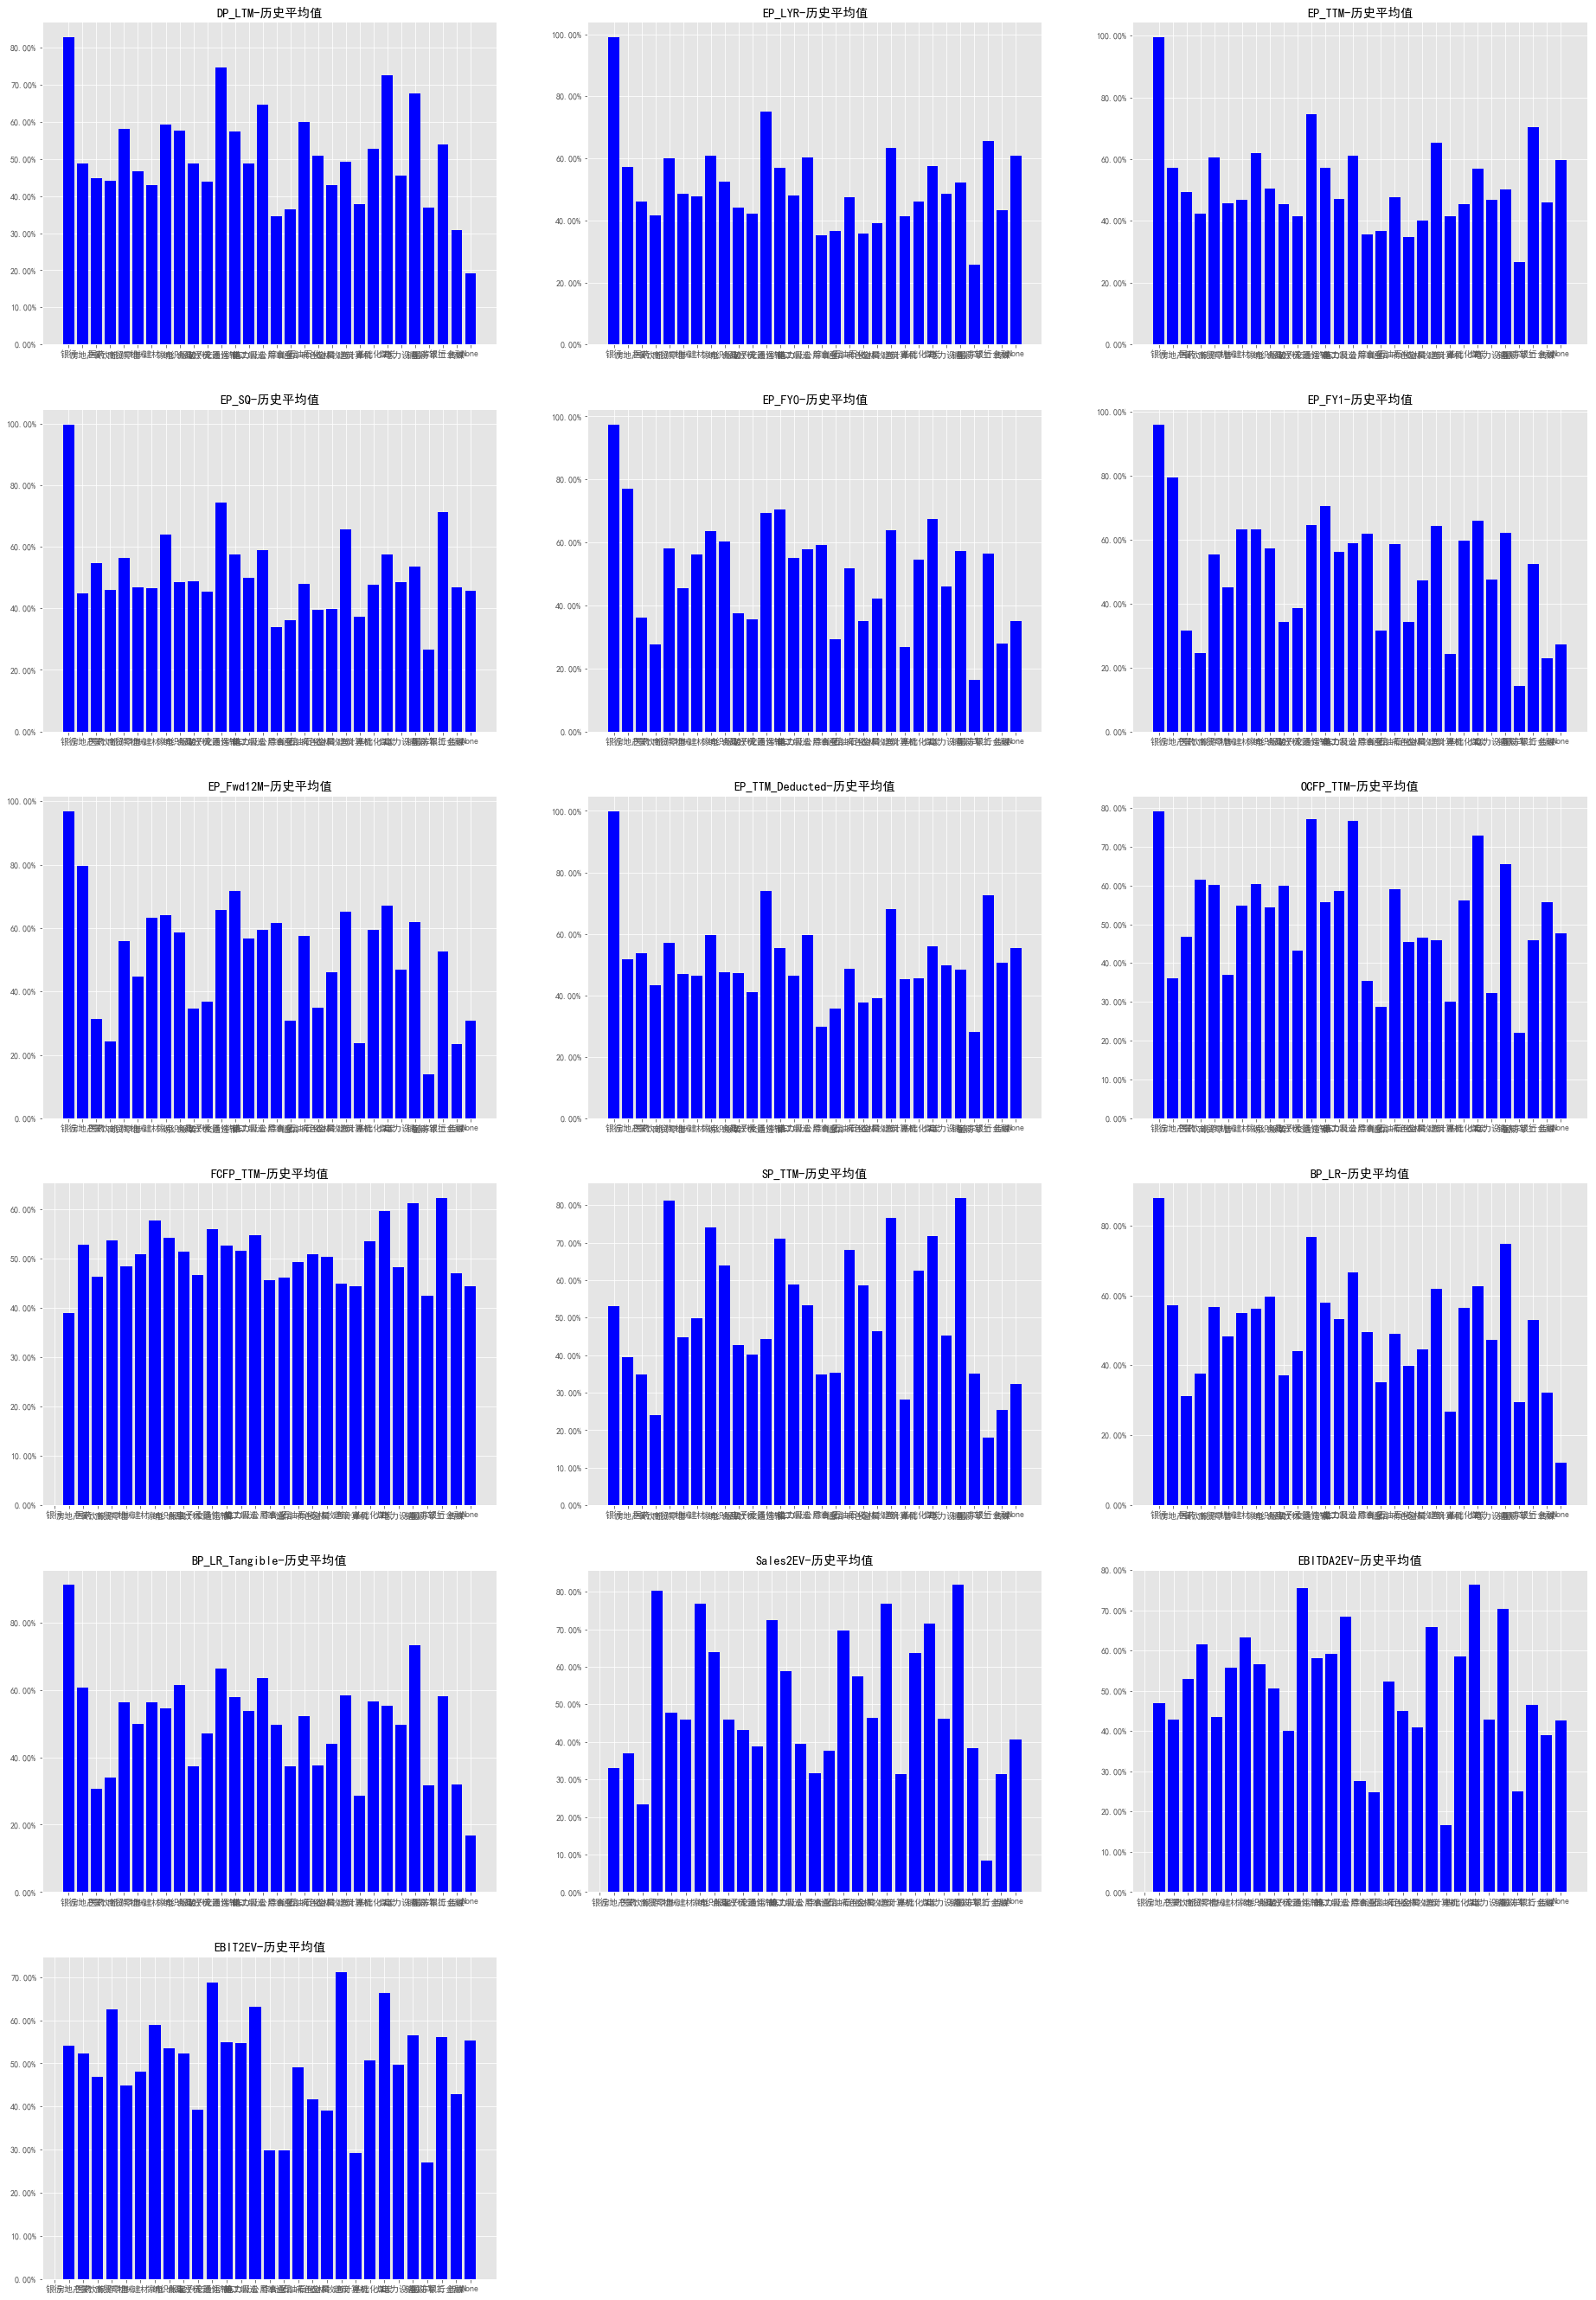

In [3]:
if __name__=='__main__':
    import matplotlib
    matplotlib.pyplot.ioff()
    import QuantStudio.api as QS
    
    # 创建因子库
    HDB = QS.FactorDB.HDF5DB()
    HDB.connect()
    
    # 创建自定义因子表
    MainFT = QS.FactorDB.CustomFT("MainFT")
    ElementaryFT = HDB.getTable("ElementaryFactor")
    DTs = ElementaryFT.getDateTime(ifactor_name="复权收盘价", start_dt=dt.datetime(2007, 1, 1), end_dt=dt.datetime(2018, 1, 1))
    MonthLastDTs = QS.Tools.DateTime.getMonthLastDateTime(DTs)
    FactorNames = FactorInfo.index.tolist()
    MainFT.addFactors(factor_table=ElementaryFT, factor_names=["复权收盘价", "中信行业", "是否在市"], args={})
    ValueFT = HDB.getTable("StyleValueFactor")
    Mask = (ElementaryFT.getFactor("是否在市")==1)
    Factors = [QS.FactorDB.FactorTools.standardizeZScore(ValueFT.getFactor(iFactorName), mask=Mask, factor_name=iFactorName) for iFactorName in ValueFT.FactorNames]# 截面标准化处理
    MainFT.addFactors(factor_list=Factors)
    MainFT.setDateTime(MonthLastDTs)
    MainFT.setID(ElementaryFT.getID(ifactor_name="复权收盘价"))
    
    # 创建回测模型
    Model = QS.BackTest.BackTestModel()
    # --------因子测试模块--------
    # IC 测试
    iModule = QS.BackTest.SectionFactor.IC(factor_table=MainFT)
    iModule["测试因子"] = FactorNames
    iModule["排序方向"] = FactorInfo["排序方向"].loc[FactorNames].to_dict()
    iModule["价格因子"] = "复权收盘价"
    iModule["计算时点"] = MonthLastDTs
    iModule["筛选条件"] = "@是否在市==1"
    Model.Modules.append(iModule)
    # Fama-MacBeth 回归
    iModule = QS.BackTest.SectionFactor.FamaMacBethRegression(factor_table=MainFT)
    iModule["测试因子"] = FactorNames
    iModule["价格因子"] = "复权收盘价"
    iModule["计算时点"] = MonthLastDTs
    iModule["筛选条件"] = "@是否在市==1"
    Model.Modules.append(iModule)
    # 因子值的行业分布
    iModule = QS.BackTest.SectionFactor.IndustryDistribution(factor_table=MainFT)
    iModule["测试因子"] = FactorNames
    iModule["行业因子"] = "中信行业"
    iModule["计算时点"] = MonthLastDTs
    iModule["筛选条件"] = "@是否在市==1"
    Model.Modules.append(iModule)
    # 因子相关性
    iModule = QS.BackTest.SectionFactor.SectionCorrelation(factor_table=MainFT)
    iModule["测试因子"] = FactorNames
    iModule["排序方向"] = FactorInfo["排序方向"].loc[FactorNames].to_dict()
    iModule["计算时点"] = MonthLastDTs
    iModule["相关性算法"] = ["spearman"]
    iModule["筛选条件"] = "@是否在市==1"
    Model.Modules.append(iModule)
    
    # 运行模型
    TestDateTimes = MainFT.getDateTime()
    Model.run(dts=TestDateTimes)
    
    # 查看结果
    display(Model)

从 IC 来看, 价值因子有一定的选股能力, 但波动性较大; 从因子值的行业分布来看, 价值因子在行业上的分布不均匀, 这说明价值因子有一定的行业偏离, 下面我们测试其行业调整的 IC:

==========历史回测==========
1. 初始化耗时 : 2.70
2. 循环计算

100%|████████████████████████████████████████| 132/132 [02:42<00:00,  1.23s/it]


耗时 : 162.72
3. 结果生成耗时 : 0.10
总耗时 : 165.53


,平均值,标准差,最小值,最大值,IC_IR,t统计量,平均股票数,IC×Sqrt(N),有效期数
BP_LR,5.20%,10.42%,-16.23%,31.90%,0.4995,5.72,2228.36,2.46,131
BP_LR_Tangible,4.81%,9.62%,-13.80%,29.08%,0.4994,5.72,2228.36,2.27,131
DP_LTM,2.56%,9.66%,-22.33%,31.28%,0.2649,3.03,2190.14,1.20,131
EBIT2EV,2.54%,8.83%,-20.31%,29.12%,0.2881,3.30,2139.34,1.18,131
EBITDA2EV,2.82%,8.16%,-15.34%,24.85%,0.3457,3.96,2139.34,1.30,131
EP_FY0,4.76%,11.13%,-14.95%,32.63%,0.4279,4.90,1450.74,1.81,131
EP_FY1,5.79%,11.58%,-15.84%,34.91%,0.5000,5.72,1484.42,2.23,131
EP_Fwd12M,5.89%,11.48%,-17.59%,34.12%,0.5130,5.87,1476.47,2.26,131
EP_LYR,2.03%,9.38%,-22.26%,33.85%,0.2161,2.47,2180.88,0.95,131
EP_SQ,3.78%,9.86%,-20.00%,33.31%,0.3827,4.38,2191.24,1.77,131

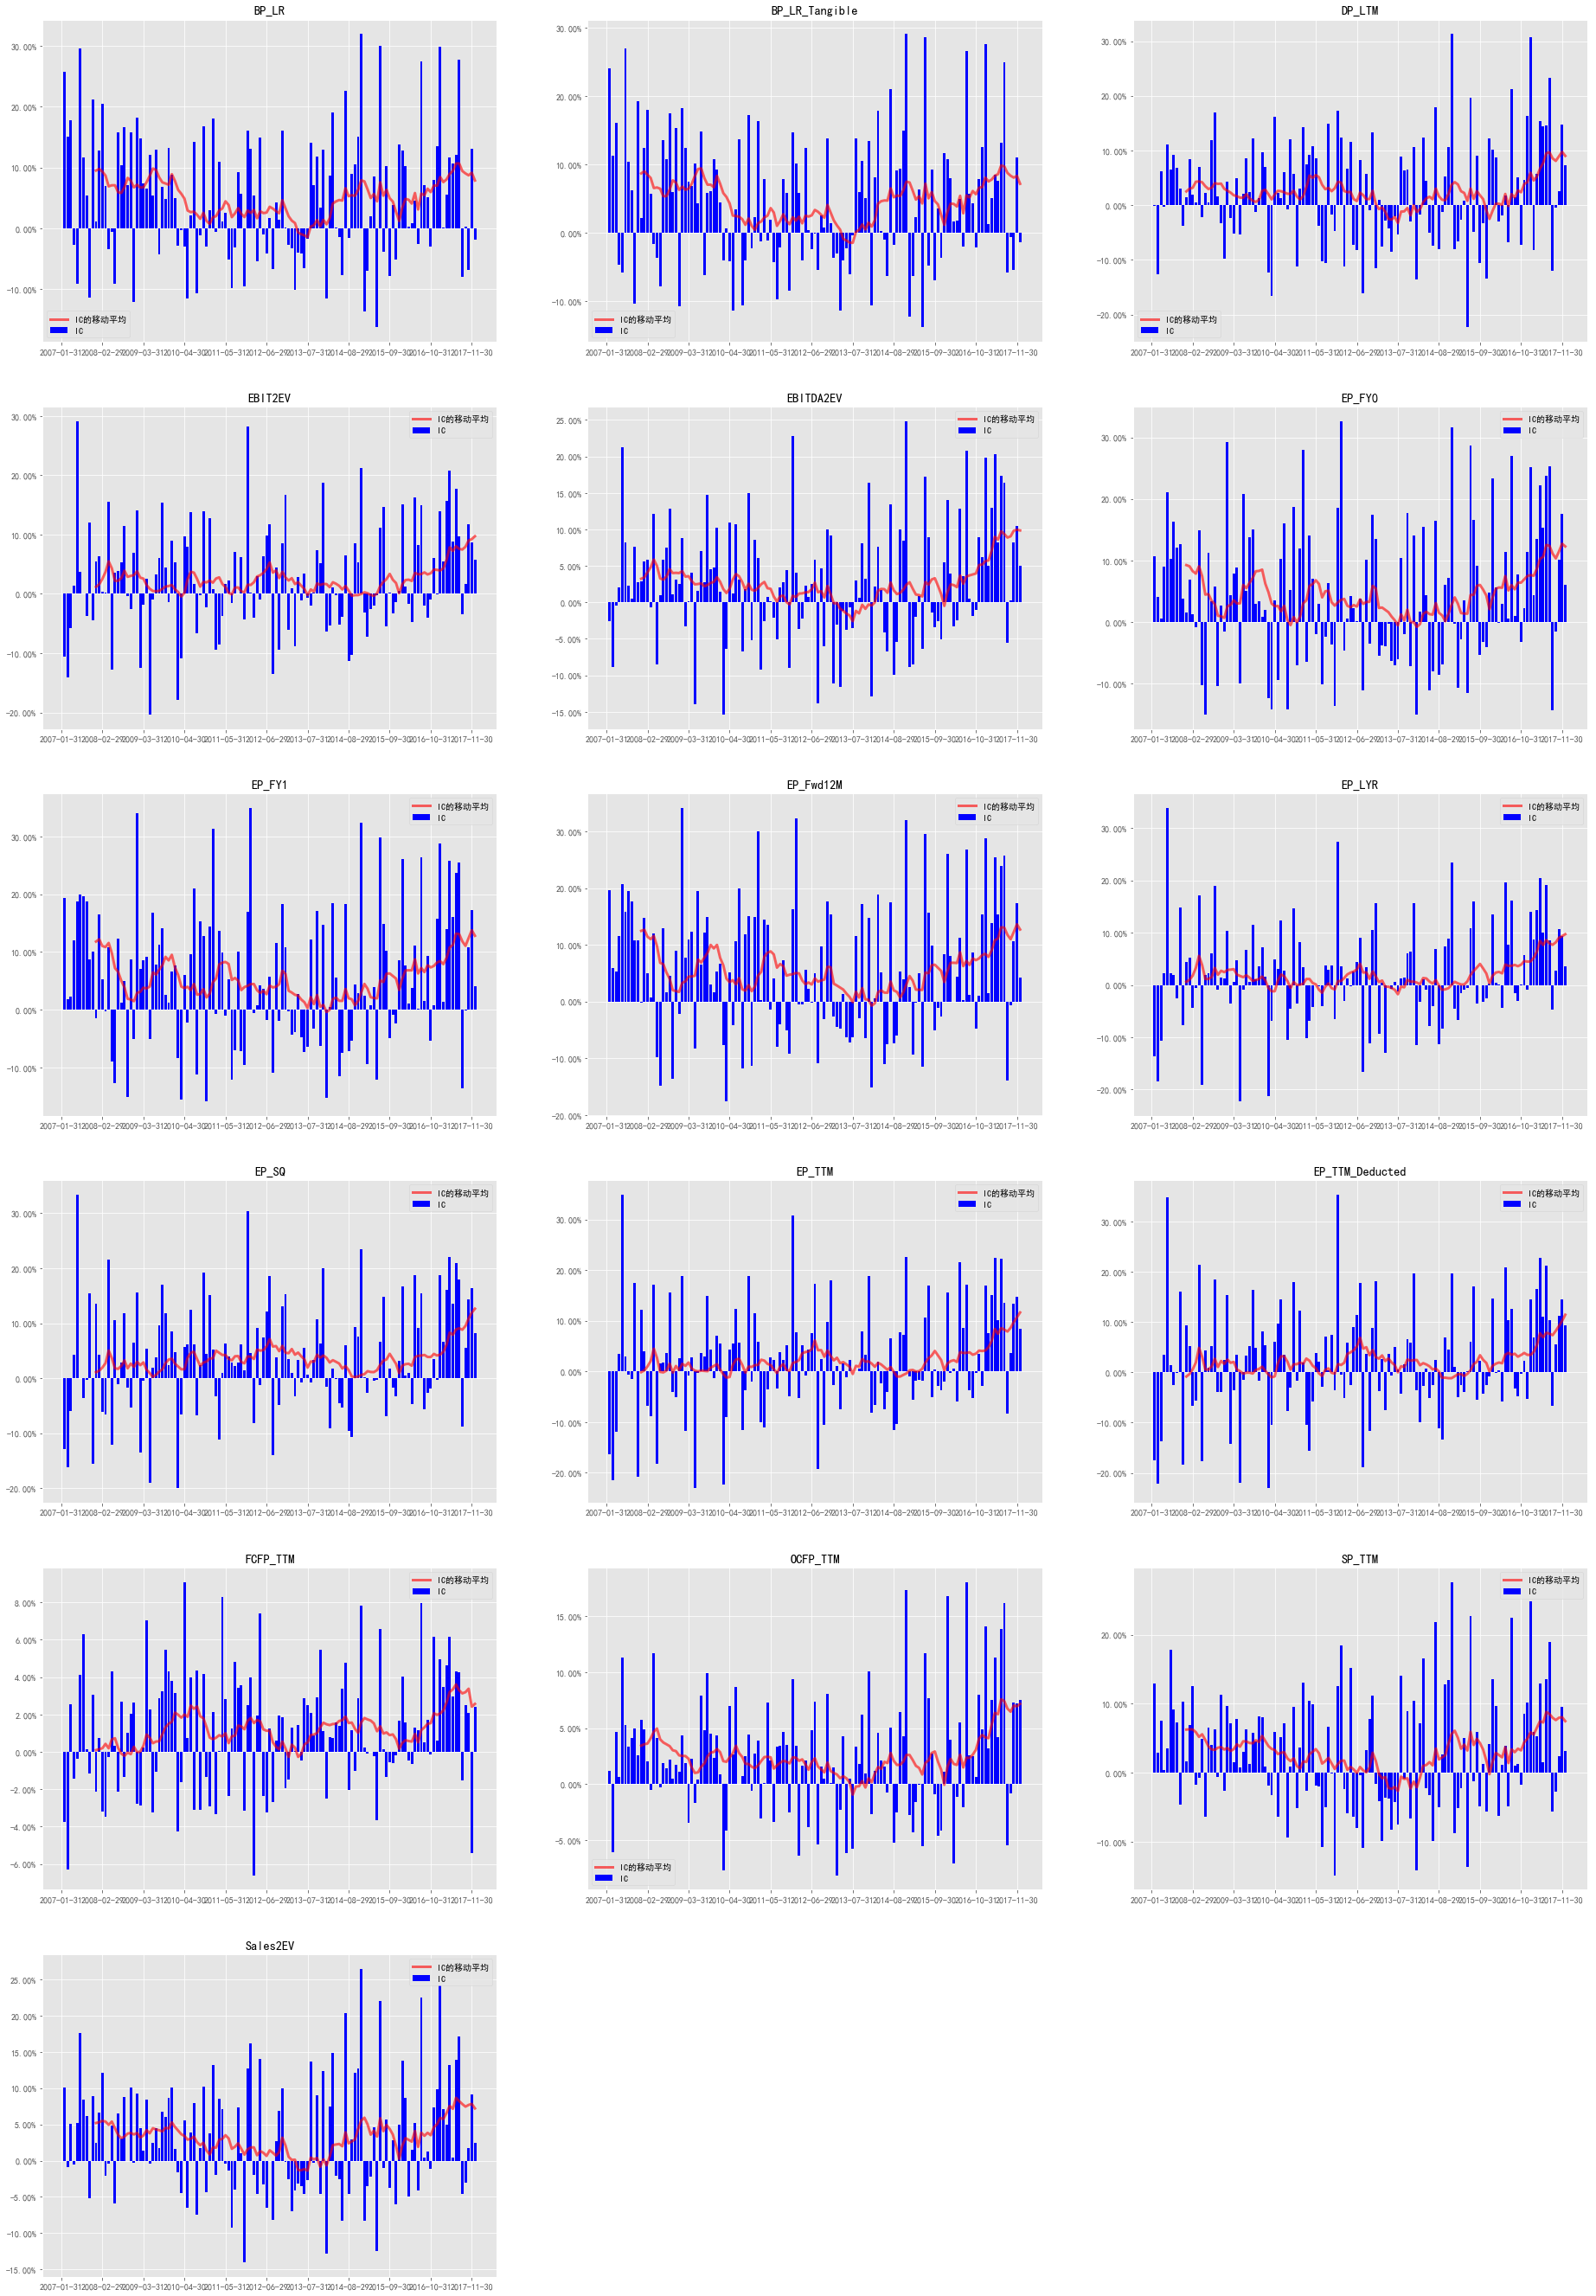

In [3]:
if __name__=='__main__':
    # 创建回测模型
    Model = QS.BackTest.BackTestModel()
    # --------因子测试模块--------
    # IC 测试
    iModule = QS.BackTest.SectionFactor.IC(factor_table=MainFT)
    iModule["测试因子"] = FactorNames
    iModule["排序方向"] = FactorInfo["排序方向"].loc[FactorNames].to_dict()
    iModule["价格因子"] = "复权收盘价"
    iModule["行业因子"] = "中信行业"
    iModule["计算时点"] = MonthLastDTs
    iModule["筛选条件"] = "@是否在市==1"
    Model.Modules.append(iModule)
    
    # 运行模型
    TestDateTimes = MainFT.getDateTime()
    Model.run(dts=TestDateTimes)
    
    # 查看结果
    display(Model)

从行业调整的 IC 来看, 价值因子的选股能力有所提升, 主要是波动性的降低. 对 A 股比较有效的价值因子为: 市净率, 用一致预期数据计算的市盈率, 以及基于现金流量表的市现率因子.

# 附录

## 财务报表

### 资产负债表(Balance Sheet)

| 资产(Assets) | 负债(Liabilities) + 所有者权益(Shareholders' Equities) |
| ---- | ---- |
| **流动资产(Current Assets)** | **流动负债(Current Liabilities)** |
| 现金及现金等价物(Cash & Cash Equivalent) | 应付账款(Accounts Payable) |
| 存货(Inventories) | 短期借款(Short-term Debt) |
| 应收账款(Accounts Receivables) | 一年内到期的非流动负债(Long-term Debt due in a year) |
| 预付账款(Prepaid Expenses) | 其他流动负债 |
| ---- | ---- |
| **非流动资产(Fixed Assets)** | **非流动负债(Long-term Liabilities)** |
| 房产、厂房及设备(Property, Plant & Equipment, PP&E) | 长期借款(Long-term Debt) |
| 长期投资(Investments) | 其他非流动负债 |
| 无形资产(Intangible Assets) |  |
| ---- | ---- |
|  | **所有者权益(Shareholders' Equities)** |
|  | 优先股(Preferred Stock) |
|  | 普通股(Common Stock) |


### 利润表(Income Statement)

| 运算 | 项目 |
| ---- | ---- |
|   | 营业总收入(Gross Sales) |
| - | 退货, 折让和折扣(Returns, Allowances and Discounts) |
| = | 营业净收入(Net Sales) |
| - | 营业成本(Cost of Goods Sold, COGS) |
| = | 毛利(Gross Profit) |
| - | 营业费用(Operating Expenses) |
| = | 息税折旧及摊销前利润(Earnings before Interest, Taxes, Depreciation and Amortization, EBITDA) |
| - | 折旧及摊销(Depreciation and Amortization) |
| = | 营业利润(Operating Income) |
| + | 营业外收入(Non-operating Income) |
| = | 息税前利润(Earnings before Interest and Taxes, EBIT) |
| - | 利息费用(Interest Expenses) |
| = | 税前利润(Income before Income Taxes) |
| - | 收入所得税(Income Taxes) |
| - | 少数股东损益(Minority Interest) |
| = | 持续经营收益(Income from Continuing Operations) |
| + | Extraordinary Items and Discontinued Operations) |
| = | 净利润(Net Income) |


### 现金流量表(Cash Flow Statement)

| 运算 | 项目 |
| ---- | ---- |
|   | 经营活动产生的现金流量(Cash Flow from Operations, CFO) |
| + | 投资活动产生的现金流量(Cash Flow from Investing) |
| + | 融资活动产生的现金流量(Cash Flow from Financing) |
| = | 现金及现金等价物净增加额(Change in Cash and Cash Equivalent) |

## 财务指标

### 变现能力

变现能力是企业产生现金的能力, 它取决于可以在近期转变为现金的流动资产的多少.

**流动比率**

公式: 流动比率 = 流动资产合计 / 流动负债合计

意义: 体现企业的偿还短期债务的能力. 流动资产越多, 短期债务越少, 则流动比率越大, 企业的短期偿债能力越强. 

分析提示: 低于正常值, 企业的短期偿债风险较大。一般情况下, 营业周期、流动资产中的应收账款数额和存货的周转速度是影响流动比率的主要因素。


**速动比率**

公式: 速动比率 = (流动资产合计 - 存货) / 流动负债合计 
     保守速动比率 = 0.8 × (货币资金 + 短期投资 + 应收票据 + 应收账款净额) / 流动负债

意义: 比流动比率更能体现企业的偿还短期债务的能力。因为流动资产中, 尚包括变现速度较慢且可能已贬值的存货, 因此将流动资产扣除存货再与流动负债对比, 以衡量企业的短期偿债能力。 

分析提示: 低于 1 的速动比率通常被认为是短期偿债能力偏低。影响速动比率的可信性的重要因素是应收账款的变现能力, 账面上的应收账款不一定都能变现, 也不一定非常可靠。 

变现能力分析总提示:
* 增加变现能力的因素: 可以动用的银行贷款指标; 准备很快变现的长期资产; 偿债能力的声誉。 
* 减弱变现能力的因素: 未作记录的或有负债; 担保责任引起的或有负债。 


### 资产管理

**存货周转率**

公式: 存货周转率 = 产品销售成本 / (期初存货 + 期末存货) × 2

意义: 存货的周转率是存货周转速度的主要指标。提高存货周转率, 缩短营业周期, 可以提高企业的变现能力.

分析提示: 存货周转速度反映存货管理水平, 存货周转率越高, 存货的占用水平越低, 流动性越强, 存货转换为现金或应收账款的速度越快。它不仅影响企业的短期偿债能力, 也是整个企业管理的重要内容。


**存货周转天数**

公式: 存货周转天数 = 360 / 存货周转率 
                   = 360 × (期初存货 + 期末存货) / 2 / 产品销售成本 
意义: 企业购入存货、投入生产到销售出去所需要的天数。提高存货周转率, 缩短营业周期, 可以提高企业的变现能力。

分析提示: 存货周转速度反映存货管理水平, 存货周转速度越快, 存货的占用水平越低, 流动性越强, 存货转换为现金或应收账款的速度越快。它不仅影响企业的短期偿债能力, 也是整个企业管理的重要内容。
 
分析时应注意的问题:
* 计算存货周转率时, 使用“销售收入”还是“销售成本”作为周转额, 看分析的目的。如果分析目的是判断短期偿债能力, 应采用销售收入。如果分析目的是评估存货管理业绩, 应当使用销售成本.
* 存货周转天数不是越低越好。比如, 减少存货量, 可以缩短周转天数, 但可能会对正常的经营活动带来不利影响。 
* 应注意应付款项、存货和应收账款(或销售)之间的关系。 
* 应关注构成存货的产成品、自制半成品、原材料、在产品和低值易耗品之间的比例关系。正常的情况下, 各类存货之间存在某种比例关系, 如果某一类的比重发生明显的大幅度变化, 可能就暗示存在某种问题。比如, 产成品大量增加, 其他项目减少, 很可能销售不畅, 放慢了生产节奏, 此时, 总的存货余额可能并没有显著变化, 甚至尚未引起存货周转率的显著变化。
 
**应收账款周转率**

定义: 指定的分析期间内应收账款转为现金的平均次数。 

公式: 应收账款周转率 = 销售收入 / (期初应收账款 + 期末应收账款) × 2

意义: 应收账款周转率越高, 说明其收回越快。反之, 说明营运资金过多呆滞在应收账款上, 影响正常资金周转及偿债能力.

分析提示: 应收账款周转率, 要与企业的经营方式结合考虑。以下几种情况使用该指标不能反映实际情况:
* 季节性经营的企业
* 大量使用分期收款结算方式
* 大量使用现金结算的销售
* 年末大量销售或年末销售大幅度下降

**应收账款周转天数**

定义: 表示企业从取得应收账款的权利到收回款项、转换为现金所需要的时间。

公式: 应收账款周转天数 = 360 / 应收账款周转率 
                       = (期初应收账款 + 期末应收账款) / 2 / 产品销售收入 
                       
意义: 应收账款周转率越高, 说明其收回越快。反之, 说明营运资金过多呆滞在应收账款上, 影响正常资金周转及偿债能力。
 
分析提示: 应收账款周转率, 要与企业的经营方式结合考虑. 使用该指标不能反映实际情况的情形类似应收账款周转率.


**营业周期**

公式: 营业周期 = 存货周转天数 + 应收账款周转天数

意义: 营业周期是从取得存货开始到销售存货并收回现金为止的时间。一般情况下, 营业周期短, 说明资金周转速度快, 营业周期长, 说明资金周转速度慢。

分析提示: 营业周期, 一般应结合存货周转情况和应收账款周转情况一并分析。营业周期的长短, 不仅体现企业的资产管理水平, 还会影响企业的偿债能力和盈利能力。

**流动资产周转率**

公式: 流动资产周转率 = 销售收入 / (期初流动资产 + 期末流动资产) × 2

意义: 流动资产周转率反映流动资产的周转速度, 周转速度越快, 会相对节约流动资产, 相当于扩大资产的投入, 增强企业的盈利能力. 而延缓周转速度, 需补充流动资产参加周转, 形成资产的浪费, 降低企业的盈利能力。 

分析提示: 流动资产周转率要结合存货、应收账款一并进行分析, 和反映盈利能力的指标结合在一起使用, 可全面评价企业的盈利能力。

**总资产周转率**

公式: 总资产周转率 = 销售收入 / (期初资产总额 + 期末资产总额) × 2

意义: 该项指标反映总资产的周转速度, 周转越快, 说明销售能力越强。企业可以采用薄利多销的方法, 加速资产周转, 带来利润绝对额的增加。

分析提示: 总资产周转指标用于衡量企业运用资产赚取利润的能力。经常和反映盈利能力的指标一起使用, 全面评价企业的盈利能力。


### 负债比率

负债比率是反映债务和资产、净资产关系的比率。它反映企业偿付到期长期债务的能力。

**资产负债率**

公式: 资产负债率 = 负债总额 / 资产总额 × 100%

意义: 反映债权人提供的资本占全部资本的比例。该指标也被称为举债经营比率。
 
分析提示: 负债比率越大, 企业面临的财务风险越大, 获取利润的能力也越强。如果企业资金不足, 依靠欠债维持, 导致资产负债率特别高, 偿债风险就应该特别注意了。资产负债率在 60%~70%, 比较合理、稳健. 达到 85% 及以上时, 应视为发出预警信号, 企业应提起足够的注意。

**产权比率**

公式: 产权比率 = 负债总额 / 股东权益 × 100%

意义: 反映债权人与股东提供的资本的相对比例。反映企业的资本结构是否合理、稳定。同时也表明债权人投入资本受到股东权益的保障程度。
 
分析提示: 一般说来, 产权比率高是高风险、高报酬的财务结构, 产权比率低, 是低风险、低报酬的财务结构。从股东来说, 在通货膨胀时期, 企业举债, 可以将损失和风险转移给债权人, 在经济繁荣时期, 举债经营可以获得额外的利润. 在经济萎缩时期, 少借债可以减少利息负担和财务风险。

**有形净值债务率**

公式: 有形净值债务率 = (负债总额 / (股东权益 - 无形资产净值) × 100%

意义: 产权比率指标的延伸, 更为谨慎、保守地反映在企业清算时债权人投入的资本受到股东权益的保障程度。不考虑无形资产包括商誉、商标、专利权以及非专利技术等的价值, 它们不一定能用来还债, 为谨慎起见, 一律视为不能偿债。
 
分析提示: 从长期偿债能力看, 较低的比率说明企业有良好的偿债能力, 举债规模正常。

**已获利息倍数**

公式: 已获利息倍数 = 息税前利润 / 利息费用 
                   = (利润总额 + 财务费用) / (财务费用中的利息支出 + 资本化利息)

近似公式: 已获利息倍数 = (利润总额 + 财务费用) / 财务费用 
 
意义: 企业经营业务收益与利息费用的比率, 用以衡量企业偿付借款利息的能力, 也叫利息保障倍数。只要已获利息倍数足够大, 企业就有充足的能力偿付利息。

分析提示: 企业要有足够大的息税前利润, 才能保证负担得起资本化利息。该指标越高, 说明企业的债务利息压力越小。


### 盈利能力

盈利能力就是企业赚取利润的能力。不论是投资人还是债务人, 都非常关心这个项目。在分析盈利能力时, 应当排除证券买卖等非正常项目、已经或将要停止的营业项目、重大事故或法律更改等特别项目、会计政策和财务制度变更带来的累积影响数等因素。

**销售净利率**

公式: 销售净利率 = 净利润 / 销售收入 × 100%

意义: 该指标反映每一元销售收入带来的净利润是多少。表示销售收入的收益水平。

分析提示: 企业在增加销售收入的同时, 必须要相应获取更多的净利润才能使销售净利率保持不变或有所提高。销售净利率可以分解成为销售毛利率、销售税金率、销售成本率、销售期间费用率等指标进行分析。


**销售毛利率**

公式: 销售毛利率 = (销售收入 - 销售成本) / 销售收入 × 100% 

意义: 表示每一元销售收入扣除销售成本后, 有多少钱可以用于各项期间费用和形成盈利。
 
分析提示: 销售毛利率是企业是销售净利率的最初基础, 没有足够大的销售毛利率便不能形成盈利。企业可以按期分析销售毛利率, 据以对企业销售收入、销售成本的发生及配比情况作出判断。

**资产净利率(总资产报酬率)**

公式: 资产净利率 = 净利润 / (期初资产总额 + 期末资产总额) × 2 × 100%

意义: 把企业一定期间的净利润与企业的资产相比较, 表明企业资产的综合利用效果。指标越高, 表明资产的利用效率越高, 说明企业在增加收入和节约资金等方面取得了良好的效果, 否则相反。

分析提示: 资产净利率是一个综合指标。净利的多少与企业的资产的多少、资产的结构、经营管理水平有着密切的关系。影响资产净利率高低的原因有: 产品的价格、单位产品成本的高低、产品的产量和销售的数量、资金占用量的大小。可以结合杜邦财务分析体系来分析经营中存在的问题。


**净资产收益率(权益报酬率)**

公式: 净资产收益率 = 净利润 / (期初所有者权益合计 + 期末所有者权益合计) × 2 × 100%

意义: 净资产收益率反映公司所有者权益的投资报酬率, 也叫净值报酬率或权益报酬率, 具有很强的综合性, 是最重要的财务比率。
 
分析提示: 杜邦分析体系可以将这一指标分解成相联系的多种因素, 进一步剖析影响所有者权益报酬的各个方面。如资产周转率、销售利润率、权益乘数。另外, 在使用该指标时, 还应结合对“应收账款”、“其他应收款” 、“待摊费用”进行分析。


## 现金流量分析

现金流量管理是财务管理中一项基本而重要的内容。企业在实际经营过程中, 关注利润指标是必要的, 但是如果仅仅关注利润指标而忽视现金流量指标, 企业就有可能陷入财务危机。无数企业成败的经验告诉我们, 现金流量是决定企业兴衰存亡的一个重要因素, 最能反映企业本质, 也比利润更能反映企业的偿债能力。
 
### 现金及现金流量
 
在《企业会计准则》中, 对现金的定义是: 指企业库存现金以及可以随时用于支付的存款。现金等价物, 指企业持有的期限短、流动性强、易于转换为已知金额现金、价值变动风险很小的投资(以下在提及“现金”时,除非同时提及现金等价物,均包括现金和现金等价物)。

现金和现金流量是两个不同的概念, 有的学者认为, 现金流量是客观存在于企业经营活动之中, 能动态反映企业经济活动并对其起保障与控制作用的货币收支过程。本人认为现金流量也可称现金流动量, 在企业投资决策中, 它是投资项目在其计算期内因资本循环而可能或应该发生的各项现金流入量与现金流出量的统称, 现金流量是计算项目投资决策评价指标的主要根据和重要信息, 是一个企业的血脉, 就好比人体的血液, 只有血液流畅循环, 人体才能健康生存。如果企业在经营活动中有充足的现金流保障、畅通的融资渠道、充裕的收益现金流, 那么企业将会健康良性地发展; 反之, 则会停滞不前, 甚至陷入财务危机。
 
### 现金流量表
 
现金流量表是一张透视企业现金流动状况的财务报表, 综合反映了企业在一定时期内的经营活动、投资活动和融资活动方面现金的流动状况。要了解一个企业的现金流量情况以及分析财务风险, 很大一部分信息都将来自现金流量表。现金流量表包括正表和补充资料两个部分:
* 正表结构包括经营活动产生的现金流量、投资活动产生的现金流量和融资活动产生的现金流量三个部分, 其中每一部分都包含现金流入量、现金流出量和现金流量净额。
* 补充资料一方面是反映有关公司的重大投资及筹资活动情况, 另一方面是通过间接法对主表中所披露的经营活动产生的现金流量净额的数额予以验证, 同时使现金及现金等价物净增加情况与资产负债表的货币资金的数额相核对。
 
### 财务风险 

企业的财务风险是指在各项财务活动过程中, 由于各种难以预料或控制的因素影响, 财务状况具有不确定性, 从而使企业有蒙受损失的可能性。但是, 在市场经济条件下, 财务风险是客观存在的, 要完全消除风险及其影响是不现实的, 只能是最大限度地控制、降低企业的财务风险, 而要做到这点, 就必须做到了解风险的来源和特征, 正确预测、衡量财务风险, 进行适当的控制和防范, 健全风险管理机制, 将损失降至最低程度, 为企业创造最大的收益。 

企业的财务活动贯穿于生产经营的整个过程中, 筹措资金、长短期投资、分配利润等都可能产生风险。因此, 根据风险的来源, 可将财务风险划分如下: 筹资风险、投资风险、现金流量风险、外汇风险。

正确了解财务风险的来源和种类是进行财务风险预测和衡量的前提。现在对现金流量的分析大部分都是由现金流量表中的数据组成相关的指标进行分析, 其次是对整个现金流量表的结构百分比来分析, 根据连续年度的报表相关项目, 预测变动趋势, 这些都是长久以来的分析方法, 也是最有说服力的方法, 在许多财务管理的书籍中都有提到。本人将通过这些对现金流量的分析方法, 解读企业的财务风险。 

对现金流量的初步分析, 企业现金流量表中, 最影响企业财务状况的三部分为: 经营活动产生的现金流量、投资活动产生的现金流量以及筹资活动产生的现金流量。现金流量结构十分重要, 总量相同的现金流量在经营活动、投资活动、筹资活动分布不同, 则意味着企业不同的发展周期和财务状况。也就是说, 只需有一张现金流量表, 就可以通过这三部分的净额对企业的财务状况做一个初步的分析和了解, 总结后大致可分为以
下几类:
 
| 经营活动的现金净流量 | 投资活动的现金净流量 | 筹资活动的现金净流量 |
| ---- | ---- | ---- |
| 正数 | 正数 | 正数 |
| 正数 | 正数 | 负数 |
| 正数 | 负数 | 正数 |
| 正数 | 负数 | 负数 |
| 负数 | 正数 | 正数 |
| 负数 | 正数 | 负数 |
| 负数 | 负数 | 正数 |
| 负数 | 负数 | 负数 |

根据上表, 通过现金净流量情况, 可分为八种情况对企业财务状况进行初步的分析了解, 以下一一说明: 
* 第一行: 此种情况的现金流量, 说明企业正处于兴盛时期, 从经营活动和投资活动的正数可以看出企业一方面保持盈利态势, 同时积极寻求扩大经营规模, 企业内部积累与外部投资同步进行, 资金使用率很高。但企业在投资收益状况良好之时, 仍然进行筹资, 这从筹资活动的正数可以看出, 如果没有新的投资机会, 将会造成资金浪费。 
* 第二行: 此种情况的现金流量, 说明企业进入产品成熟期, 从经营和投资活动的正数说明企业的经营和投资良性循环, 筹资活动的负数是由于偿还借款引起的, 不足以威胁企业的财务状况。在这个阶段, 产品销售市场较稳定, 已进入投资回收期, 但必须注意及时偿还外部资金, 防止企业的资信程度带来的经济风险。
* 第三行: 此种情况的现金流量, 说明企业正处于扩张时期, 产品迅速占领市场, 销售呈快速上升趋势, 表现为经营活动中资金大量回笼, 从投资活动的负数看出企业为了扩大市场份额, 继续大量追加投资, 而仅靠经营活动的现金流量净额可能无法满足所需投资, 必须通过筹集资金进行投资。这时应该着重分析投资项目的盈利能力。 
* 第四行: 此种情况的现金流量, 说明企业经营状况虽然良好。筹资活动的负数说明企业正在偿还以前债务, 同时, 从投资活动的负数看出企业还继续投资, 所以应随时关注经营状况的变化, 防止财务状况恶化。 
* 第五行: 此情况的现金流量, 说明企业由于过度扩张, 经营活动的负数已经开始说明企业经营状况不佳, 即使是主营业务也不能为其带来现金流入, 企业入不敷出, 只能依赖于借债度日, 企业全面萎缩, 财务状况可能恶化。但投资活动是正数, 此时应着重分析投资活动的现金净流入是来自投资收益或是撤回投资, 若为后者, 则企业的形式将十分严峻。 
* 第六行: 此种情况的现金流量, 可以认为企业处于衰退期。这个时期的特征是, 市场萎缩, 产品销售的市场占有率下降, 经营活动的现金流入小于流出, 经营活动已经发出了危险信号。同时从筹资活动的负数看出企业正在偿还以前的借款, 只有靠投资活动的现金流入度日, 如果投资活动的现金流入主要来自收回投资, 则企业将处于破产的边缘, 需高度警惕。 
* 第七行: 此种情况的现金流量, 表明企业在靠筹资维持经营活动。如果是企业的初创期, 则这个阶段企业需要投入大量资金, 形成生产力, 开拓市场, 在此时期, 企业的战略重点是扩大市场份额, 现金管理的重点则应落在避免企业筹资过而背负沉重的债务。但如果这不是初创企业的现金流量情况, 则非常危险, 经营活动和投资活动的现金流出大于流入, 企业的现金来源都是靠举债, 如果投资活动和经营活动继续恶化, 则企业支不抵债, 需引起高度注意, 并应立即采取针对性措施。 
* 第八行: 此种情况的现金流量, 是最危险的财务信号, 说明企业的财务状况危急, 必须及时扭转。该情况往往发生在扩张时期, 企业加快了筹资步伐, 实现全面扩张, 想发展成为具有市场影响力的大集团。但当企业过度扩张时, 盲目地增加投资, 各项投资不能在短时间内为企业带来现金流入, 同时在扩张时期的各项筹资到期都需要支付筹资费用, 导致企业饱受过度扩张之苦, 使企业陷入进退两难的境地。此时, 必须把握企业扩张的尺度, 合理运用好各种杠杆, 有时甚至需要放弃或改变原的战略, 降低企业的财务风险。

 
### 偿债能力风险 

**流动现金偿付债务能力率**

公式: 流动现金偿付债务能力率 = 经营活动产生的现金流量 / (期初流动负债余额 + 期末流动负债余额) × 2

真正能够用来偿债的是经营净现金流量。经营现金净流量与流动负债平均值的比, 就是流动现金偿付能力比率, 它能更好地反映企业偿还短期债务的能力。该比率越高, 说明企业流动现金偿债能力越强, 用时期平均数比用时点平均数要更科学, 因此使用流动债务平均值, 通过对现金流动性研究证实, 对一个企业来说, 比率大于或等于 40%, 其流动性比较合理。

**现金比率** 

公式: 现金比率 = 期末现金余额 / 流动负债
 
用企业期末的现金余额与企业的流动负债之比, 判断企业的偿债风险。由于流动负债期限短(不超过一年), 很快就需要用现金来偿还, 如果企业手中没有一定量的现金储备, 在债务到期时就容易出现问题。 

**经营净现金与全部负债之比**

公式: 经营净现金与全部负债之比 = 经营活动产生的现金流量 / 全部负债

此比值用以恒量企业年度经营活动现金净流量偿付全部负债的能力, 能够综合地反映企业偿债风险状况. 《现金流量管理》在对某系统 30 家企业的现金比率进行比较发现, 现金比率在 40%-80% 之间的企业都是经营稳定、资金运转良好的企业。现金比率在 100% 以上的企业, 有的是经营情况特殊, 有的是年末由于一些原因现金余额增大, 虽然他们的资金状况良好, 但过高的现金比率会使资产过多地保留在盈利能力最低的现金上, 虽然企业没有偿债风险, 但降低了获利能力。现金比率在 20% 以下的企业, 经营上存在各种问题, 其中现金紧张是共同特点, 而且其中有几家企业已经出现现金周转的极度困难, 偿债风险巨大。通过这样的分析, 我们不难得出偿债风险的预警信号, 在现金比率低于 30% 时, 企业的偿债风险加大。此时, 企业管理者们应高度重视.

### 支付能力风险
 
支付能力是指企业除了用现金偿还债务外, 用现金来支付企业的其他各项开支。企业如果没有支付能力, 拖欠职工工资, 拖欠货款, 不能如常支付股利, 不仅会造成员工队伍不稳定, 生产经营不正常, 而且会影响到投资者对企业投资的信心, 形成支付上的风险。
 
**现金支付股利能力比率** 

公式: 现金支付股利能力比率 = 经营活动产生的现金流量 / 派发股利额

现金支付股利能力比率可以反映一个公司以经营活动产生的现金流量支付当前股利的能力。比率越大, 证明企业支付能力越强, 反之, 则会形成支付风险。
 
**综合支付能力**

公式: 综合支付能力 = 本期经营活动取得的现金收入加 + 投资活动取得的现金收入 - 偿还债务的现金支出 - 经营活动的各项支出
 
该指标如果大于零, 说明企业当期经营活动的现金收入和投资活动取得的现金收入足以支付本期的债务和日常经营活动支出, 可以有一部分余额用于投资和分派股利, 反之则无法用于投资活动和分派股利。如果这种状况持续下去, 得不到扭转, 则说明企业面临支付风险。

 
### 未来现金流量能力风险
 
对未来现金流量能力的分析主要采用的是趋势分析法, 这是现金流分析的一种常用方法, 通过对企业不同时期的现金流量数据进行对比分析, 揭示企业在财务状况或经营成果方面是改善还是恶化, 并预测企业未来的现金流量的走向, 有效的防范控制未来现金流量风险。

**环比式比率趋势分析** 

公式: 环比增长率 = (本期实际数 - 上期实际数) / 上期实际数

环比式比率趋势分析是指以环比增长率为依据观察指标变动趋势, 直观地分析未来现金流量的发展趋势, 对现金的收入和支出速度和趋势进行分析, 同时可以对经营活动, 筹资活动, 投资活动分开分析, 把企业的未来风险分解开, 从根本上去防范。

**定基式趋势百分比分析**

公式: 某期趋势百分比 = (某期实际数 - 基期实际数) / 基期实际数
 
定基式趋势百分比分析是指以某一年为基期, 计算各期的定比增长率, 以趋势百分比观察其变动趋势。这种分析法主要是与基期相比, 观察每期相对基期的变化, 从中发现问题, 可以从企业的现金流量在经营活动、投资活动、筹资活动的变化分析企业的投资是否有回报, 对筹资的依赖性、经济效益是否有提高以及投资的力度等情况, 合理规划企业未来的现金流向, 及时发现企业潜在的财务风险。

### 流动性分析

流动性分析是将资产迅速转变为现金的能力。

**现金到期债务比**

公式: 现金到期债务比 = 经营活动现金净流量 / 本期到期的债务
 
本期到期债务 = 一年内到期的长期负债 + 应付票据 

意义: 以经营活动的现金净流量与本期到期的债务比较, 可以体现企业的偿还到期债务的能力。

分析提示: 企业能够用来偿还债务的除借新债还旧债外, 一般应当是经营活动的现金流入才能还债。


**现金流动负债比**

公式: 现金流动负债比 = 年经营活动现金净流量 / 期末流动负债 

意义: 反映经营活动产生的现金对流动负债的保障程度。 

分析提示: 企业能够用来偿还债务的除借新债还旧债外, 一般应当是经营活动的现金流入才能还债。


**现金债务总额比**

公式: 现金流动负债比 = 经营活动现金净流量 / 期末负债总额 

意义: 企业能够用来偿还债务的除借新债还旧债外, 一般应当是经营活动的现金流入才能还债。

分析提示: 计算结果要与过去比较, 与同业比较才能确定高与低。这个比率越高, 企业承担债务的能力越强。这个比率同时也体现企业的最大付息能力。


### 获取现金的能力  

**销售现金比率**

公式: 销售现金比率 = 经营活动现金净流量 / 销售额

意义: 反映每元销售得到的净现金流入量, 其值越大越好。

分析提示: 计算结果要与过去比, 与同业比才能确定高与低。这个比率越高, 企业的收入质量越好, 资金利用效果越好。

**每股营业现金流量**

公式: 每股营业现金流量 = 经营活动现金净流量 / 普通股股数
 
意义: 反映每股经营所得到的净现金, 其值越大越好。
 
分析提示: 该指标反映企业最大分派现金股利的能力。超过此限, 就要借款分红。

**全部资产现金回收率**

公式: 全部资产现金回收率 = 经营活动现金净流量 / 期末资产总额 

意义: 说明企业资产产生现金的能力, 其值越大越好。

分析提示: 把上述指标求倒数, 则可以分析, 全部资产用经营活动现金回收, 需要的期间长短。因此, 这个指标体现了企业资产回收的含义。回收期越短, 说明资产获现能力越强。


### 财务弹性分析

**现金满足投资比率**

公式: 现金满足投资比率 = 近五年累计经营活动现金净流量 / 同期内的资本支出、存货增加、现金股利之和
 
取数方法: 近五年累计经营活动现金净流量应指前五年的经营活动现金净流量之和, 同期内的资本支出、存货增加、现金股利之和也从现金流量表相关栏目取数, 均取近五年的平均数. 资本支出, 从购建固定资产、无形资产和其他长期资产所支付的现金项目中取数; 存货增加, 从现金流量表附表中取数, 取存货的减少栏的相反数即存货的增加; 现金股利, 从现金流量表的主表中, 分配利润或股利所支付的现金项目取数。如果实行新的企业会计制度, 该项目为分配股利、利润或偿付利息所支付的现金, 则取数方式为, 主表分配股利、利润或偿付利息所支付的现金项目减去附表中财务费用。 

意义: 说明企业经营产生的现金满足资本支出、存货增加和发放现金股利的能力, 其值越大越好。比率越大, 资金自给率越高。

分析提示: 达到 1, 说明企业可以用经营获取的现金满足企业扩充所需资金, 若小于1, 则说明企业部分资金要靠外部融资来补充。

**现金股利保障倍数**

公式: 现金股利保障倍数 = 每股营业现金流量 / 每股现金股利 
                       = 经营活动现金净流量 / 现金股利

意义: 该比率越大, 说明支付现金股利的能力越强, 其值越大越好。
 
分析提示: 分析结果可以与同业比较, 与企业过去比较。

**营运指数**

公式: 营运指数 = 经营活动现金净流量 / 经营应得现金
 
其中, 经营所得现金 = 经营活动净收益 + 非付现费用 = 净利润 - 投资收益 - 营业外收入 + 营业外支出 + 本期提取的折旧+无形资产摊销 + 待摊费用摊销 + 递延资产摊销 

意义: 分析会计收益和现金净流量的比例关系, 评价收益质量。
 
分析提示: 接近 1, 说明企业可以用经营获取的现金与其应获现金相当, 收益质量高; 若小于1, 则说明企业的收益质量不够好。